# Interprétation

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets, convert_keys_to_int, PDF

# pdf = PDF('output/interpretation/')

t = time.time()

In [2]:
best_LR = "LR_RFECV"
best_RF = "Forest_RFECV"
best_XGB = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêt aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    RF_COLUMNS = json.load(column_file)
    RF_COLUMNS_QUANT = RF_COLUMNS['columns_quant']
    RF_COLUMNS_CAT = RF_COLUMNS['columns_cat']
    RF_COLUMNS = RF_COLUMNS_QUANT + RF_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    RF_PARAMS = json.load(param_file)[best_RF]
    RF_PARAMS = convert_keys_to_int(RF_PARAMS)

print(f'Variables explicatives forêt aléatoires ({len(RF_COLUMNS)}) :')
display(RF_COLUMNS)

print(f'Meilleurs paramètres forêt aléatoires ({len(RF_PARAMS)}) :')
RF_PARAMS['class_weight'] = {int(k): v for k,v in RF_PARAMS['class_weight'].items()}
display(RF_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XGB_COLUMNS = json.load(column_file)
    XGB_COLUMNS_QUANT = XGB_COLUMNS['columns_quant']
    XGB_COLUMNS_CAT = XGB_COLUMNS['columns_cat']
    XGB_COLUMNS = XGB_COLUMNS_QUANT + XGB_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XGB_PARAMS = json.load(param_file)[best_XGB]
    XGB_PARAMS = convert_keys_to_int(XGB_PARAMS)

print(f'Variables explicatives XGBoost ({len(XGB_COLUMNS)}) :')
display(XGB_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XGB_PARAMS)}) :')
display(XGB_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêt aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêt aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

Seuils ajustés :


{'LR': 0.5005859374999999,
 'Forest': 0.6492187500000004,
 'XGBoost': 0.4799804687499999}

# 1. Régression logistique

In [4]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
datasets_df = datasets(df, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X = datasets_df['X_only_quant_scaled']
y = datasets_df['y']

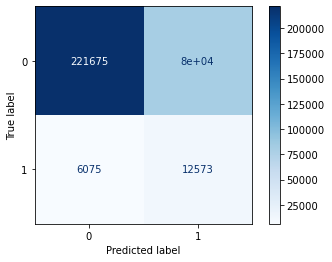

f1 : 0.2253
f3 : 0.4821
f5 : 0.5846
recall : 0.6742
negative predictive value : 0.9733
precision : 0.1353
roc_auc : 0.7731
training time : 4.014s
prediction time : 0.027s


In [5]:
m = Modelisation(X, y, LogisticRegression(**LR_PARAMS), seuil=SEUILS['LR'])
m.show_conf_matrix()
m.show_metrics_score()

In [6]:
coeffs = pd.DataFrame({"Feature": X.columns.tolist(),"Coefficients": m.model.coef_[0]})
coeffs.sort_values(by="Coefficients", ascending = False)

,Feature,Coefficients
4,zonecostineuro,0.761387
0,campaignctrlast24h,0.319630
9,is_interstitial_True,0.242325
1,display_size,0.150248
8,display_env_app_ios,0.072367
10,target_env_2,-0.069301
2,nbdayssincelastclick,-0.096038
5,campaignscenario_13,-0.129949
7,device_type_iPhone,-0.146696
3,nbdisplay_1hour,-0.156718


## 2. Random Forest

In [ ]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
datasets_df = datasets(df, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']

In [ ]:
m = Modelisation(X, y, RandomForestClassifier(**RF_PARAMS), seuil=SEUILS['Forest'])
m.show_conf_matrix()
m.show_metrics_score()

## 3. XGBoost

In [ ]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
datasets_df = datasets(df, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']

In [ ]:
m = Modelisation(X, y, RandomForestClassifier(**RF_PARAMS), seuil=SEUILS['XGBoost'])
m.show_conf_matrix()
m.show_metrics_score()

In [ ]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")